# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [1]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

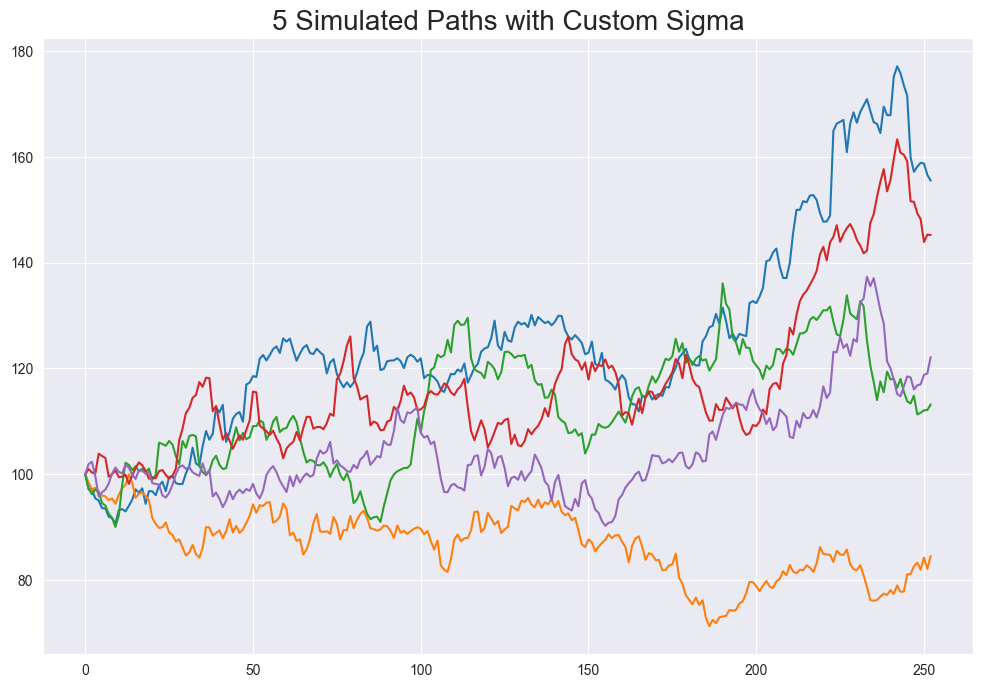

In [3]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

In [4]:
from scipy.stats import norm

def bs_price(S, K, T, r, sigma, option='call'):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
    else:
        return K * np.exp(-r*T)*norm.cdf(-d2) - S * norm.cdf(-d1)

def bs_delta(S, K, T, r, sigma, option='call'):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1) if option == 'call' else -norm.cdf(-d1)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T)/(sigma*np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)


In [5]:
def bs_price(S, K, T, r, sigma, option='call'):
    if T <= 0:
        return max(S - K, 0) if option == 'call' else max(K - S, 0)
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
    else:
        return K * np.exp(-r*T)*norm.cdf(-d2) - S * norm.cdf(-d1)

def bs_delta(S, K, T, r, sigma, option='call'):
    if T <= 0:
        return 1.0 if S > K and option == 'call' else 0.0  # final step behavior
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1) if option == 'call' else -norm.cdf(-d1)

def bs_vega(S, K, T, r, sigma):
    if T <= 0:
        return 0.0
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T)/(sigma*np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)


In [6]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    dt = t/n_steps
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    log_returns = np.cumsum(increments, axis = 1)
    paths = S0*np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis = 1)
    sigma = np.insert(sigma, 0, sigma[:, 0], axis=1)  # align with time steps
    return paths, sigma


In [7]:

def hedge_strategy(S0, K, r, t, n_paths, n_steps, strategy='delta'):
    dt = t / n_steps
    paths, sigmas = stock_path_custom_sigma(S0, t, r, mu=0, n_paths=n_paths, n_steps=n_steps)
    profits = []

    for path_idx in range(n_paths):
        stock_path = paths[path_idx]
        sigma_path = sigmas[path_idx]
        cash = 0
        position_stock = 0
        position_vega = 0  # only for sigma-hedging

        for step in range(n_steps):
            T = t - step * dt
            S = stock_path[step]
            sigma = sigma_path[step]
            next_S = stock_path[step + 1]
            next_sigma = sigma_path[step + 1]

            delta = bs_delta(S, K, T, r, sigma, option='call')
            vega = bs_vega(S, K, T, r, sigma) if strategy == 'sigma' else 0

            # Hedge adjustments
            d_stock = delta - position_stock
            d_vega = vega - position_vega if strategy == 'sigma' else 0

            cash -= d_stock * S
            cash -= d_vega * 1.0  # assume 1 "vega option unit" costs 1 unit (simplified)

            position_stock = delta
            position_vega = vega if strategy == 'sigma' else 0

            # Cash earns risk-free rate
            cash *= np.exp(r * dt)

        # Final value of hedge portfolio at T
        final_S = stock_path[-1]
        final_option_value = bs_price(final_S, K, 0, r, sigma_path[-1], option='call')
        hedge_portfolio = position_stock * final_S + cash + position_vega * 1.0  # simplified
        actual_payoff = max(final_S - K, 0)
        profit = hedge_portfolio - actual_payoff
        profits.append(profit)

    return profits


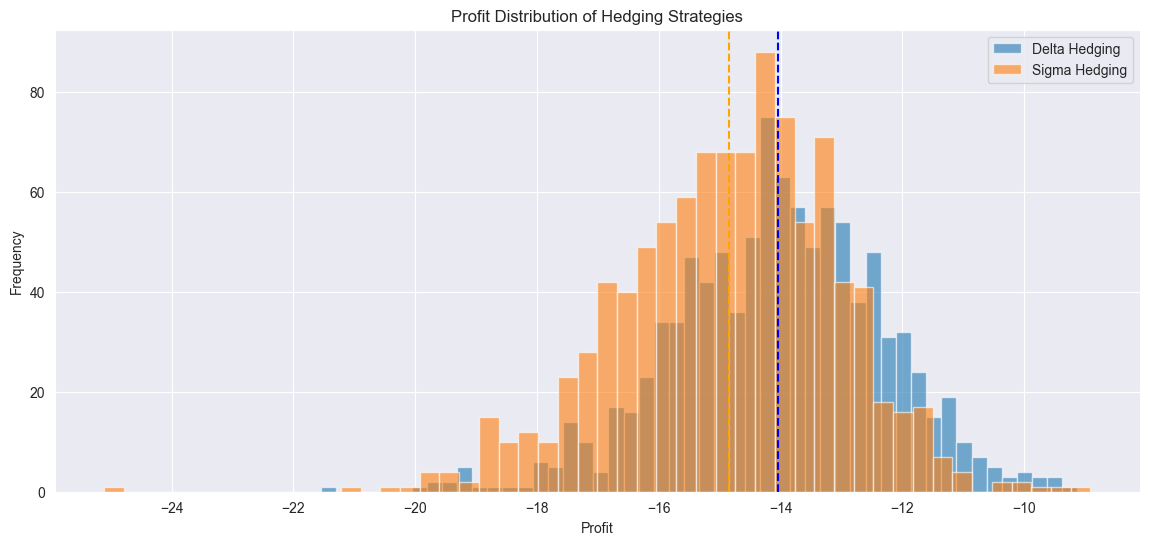

In [8]:
# Simulation Parameters
S0 = 100
K = 100
t = 1
r = 0.039
n_paths = 1000
n_steps = 252

# Run both strategies
profits_delta = hedge_strategy(S0, K, r, t, n_paths, n_steps, strategy='delta')
profits_sigma = hedge_strategy(S0, K, r, t, n_paths, n_steps, strategy='sigma')

# Plot results
plt.figure(figsize=(14,6))
plt.hist(profits_delta, bins=50, alpha=0.6, label='Delta Hedging')
plt.hist(profits_sigma, bins=50, alpha=0.6, label='Sigma Hedging')
plt.axvline(np.mean(profits_delta), color='blue', linestyle='--')
plt.axvline(np.mean(profits_sigma), color='orange', linestyle='--')
plt.title("Profit Distribution of Hedging Strategies")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
print("Delta Hedging Mean Profit:", np.mean(profits_delta))
print("Sigma Hedging Mean Profit:", np.mean(profits_sigma))

Delta Hedging Mean Profit: -14.048945887138135
Sigma Hedging Mean Profit: -14.84921803093003


**Now, let us try to generate stock paths under Hetson model.**

In [10]:
!pip install statsmodels

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
sns.set_style('darkgrid')
from scipy.optimize import minimize
from joblib import Parallel, delayed
from scipy.stats import rv_discrete
from statsmodels.stats.diagnostic import acorr_ljungbox


%run functions.py

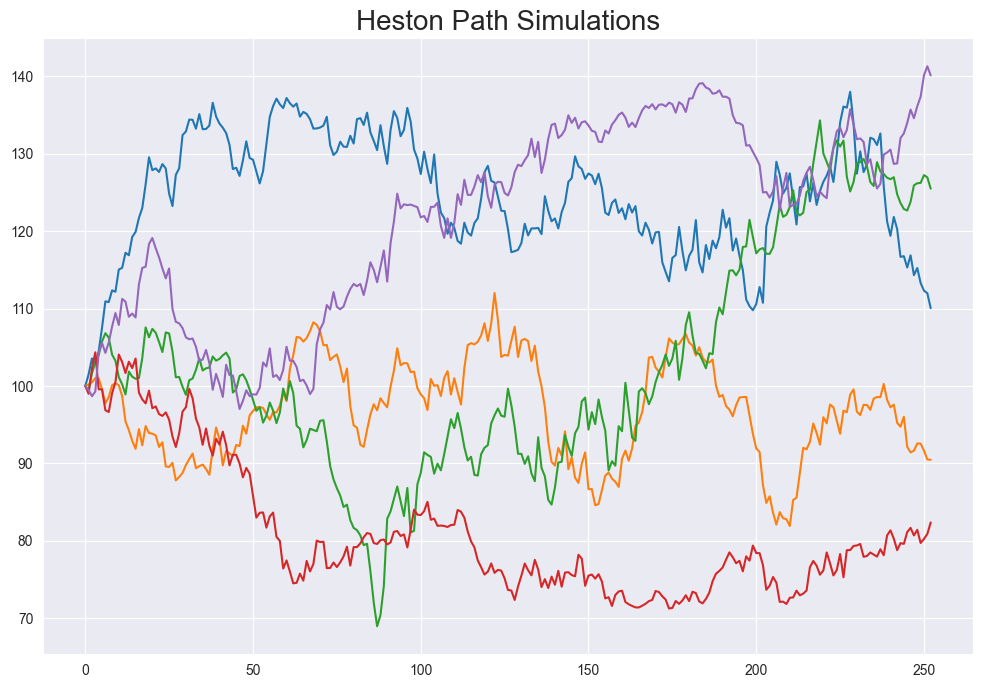

In [35]:
# the average volatility in the first case is: E[σ^2]=0.5⋅0.2**2 +0.3⋅0.3**2+0.2⋅0.45**2 =0.5(0.04)+0.3(0.09)+0.2(0.2025)=0.02+0.027+0.0405=0.0875
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = 0.0875 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = 0.0875 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 100 #Initial Stock Value

t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

n_sims = 5 #Number of simulations

mu = .0275 #Excess drift of log returns



heston_paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu)

plt.figure(figsize = (12,8))
for path in heston_paths:
    plt.plot(path)
    
    
plt.title('Heston Path Simulations', size = 20)

plt.show()

In [36]:
def simulate_heston(S0, v0, r, mu, kappa, theta, xi, rho, T, n_paths, n_steps):
    dt = T / n_steps
    S = np.zeros((n_paths, n_steps + 1))
    v = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(1, n_steps + 1):
        z1 = np.random.normal(size=n_paths)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_paths)

        v[:, t] = np.abs(v[:, t - 1] + kappa*(theta - v[:, t - 1])*dt + xi*np.sqrt(v[:, t - 1])*np.sqrt(dt)*z2)
        S[:, t] = S[:, t - 1] * np.exp((mu - 0.5*v[:, t - 1])*dt + np.sqrt(v[:, t - 1])*np.sqrt(dt)*z1)

    return S, np.sqrt(v)  # return volatility as sigma


In [37]:
def hedge_strategy_heston(S0, K, r, T, n_paths, n_steps, strategy='delta'):
    mu = 0  # risk-neutral
    S_paths, sigma_paths = simulate_heston(S0, v0=0.0875, r=r, mu=mu,
                                           kappa=kappa, theta=theta, xi=xi, rho=rho,
                                           T=T, n_paths=n_paths, n_steps=n_steps)
    dt = T / n_steps
    profits = []

    for i in range(n_paths):
        S_path = S_paths[i]
        sigma_path = sigma_paths[i]

        cash = bs_price(S0, K, T, r, sigma=0.0875, option='call')  # initial option sold
        position_stock = 0
        position_vega = 0

        for step in range(n_steps):
            t_remain = T - step * dt
            S = S_path[step]
            sigma = sigma_path[step]

            delta = bs_delta(S, K, t_remain, r, sigma, option='call')
            d_stock = delta - position_stock
            cash -= d_stock * S
            position_stock = delta

            if strategy == 'sigma':
                # use OTM option for vega hedge
                K_vega = K + 10
                vega = bs_vega(S, K, t_remain, r, sigma)
                vega_hedge_vega = bs_vega(S, K_vega, t_remain, r, sigma)
                vega_option_price = bs_price(S, K_vega, t_remain, r, sigma, option='call') if vega_hedge_vega > 1e-6 else 0.0
                cost_per_vega = vega_option_price / vega_hedge_vega if vega_hedge_vega > 1e-6 else 0.0

                d_vega = vega - position_vega
                cash -= d_vega * cost_per_vega
                position_vega = vega

            # cash earns interest
            cash *= np.exp(r * dt)

        # final portfolio
        final_S = S_path[-1]
        payoff = max(final_S - K, 0)
        hedge_value = position_stock * final_S + cash
        profit = hedge_value - payoff
        profits.append(profit)

    return profits
    


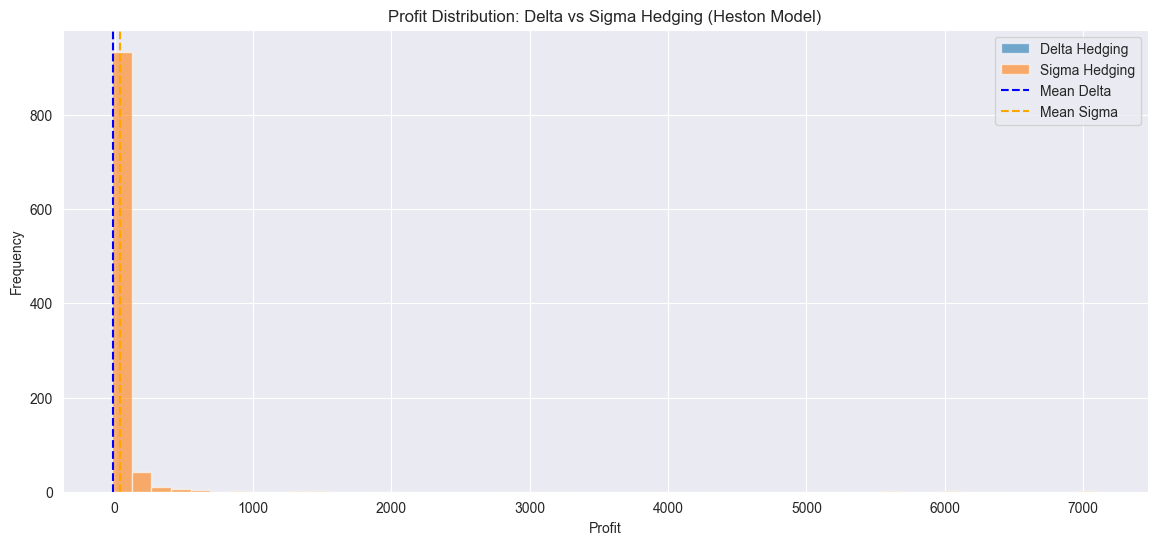

In [38]:
S0 = 100
K = 100
r = 0.039
T = 1
n_paths = 1000
n_steps = 252

profits_delta = hedge_strategy_heston(S0, K, r, T, n_paths, n_steps, strategy='delta')
profits_sigma = hedge_strategy_heston(S0, K, r, T, n_paths, n_steps, strategy='sigma')

# Plotting
plt.figure(figsize=(14,6))
plt.hist(profits_delta, bins=50, alpha=0.6, label='Delta Hedging')
plt.hist(profits_sigma, bins=50, alpha=0.6, label='Sigma Hedging')
plt.axvline(np.mean(profits_delta), color='blue', linestyle='--', label='Mean Delta')
plt.axvline(np.mean(profits_sigma), color='orange', linestyle='--', label='Mean Sigma')
plt.title("Profit Distribution: Delta vs Sigma Hedging (Heston Model)")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()


In [42]:
#Hedging streategy using Heston
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm





def hedge_strategy_heston(S0, K, r, T, n_paths, n_steps, strategy='delta'):
    mu = 0  # risk-neutral
    S_paths, sigma_paths = simulate_heston(S0, v0=0.0875, r=r, mu=mu,
                                           kappa=kappa, theta=theta, xi=xi, rho=rho,
                                           T=T, n_paths=n_paths, n_steps=n_steps)
    dt = T / n_steps
    profits = []

    for i in range(n_paths):
        S_path = S_paths[i]
        sigma_path = sigma_paths[i]

        cash = bs_price(S0, K, T, r, sigma=0.0875, option='call')  # initial option sold
        position_stock = 0
        position_vega = 0

        for step in range(n_steps):
            t_remain = T - step * dt
            S = S_path[step]
            sigma = sigma_path[step]

            delta = bs_delta(S, K, t_remain, r, sigma, option='call')
            d_stock = delta - position_stock
            cash -= d_stock * S
            position_stock = delta

            if strategy == 'sigma':
                # use OTM option for vega hedge
                K_vega = K + 10
                vega = bs_vega(S, K, t_remain, r, sigma)
                vega_hedge_vega = bs_vega(S, K_vega, t_remain, r, sigma)
                vega_option_price = bs_price(S, K_vega, t_remain, r, sigma, option='call') if vega_hedge_vega > 1e-6 else 0.0
                cost_per_vega = vega_option_price / vega_hedge_vega if vega_hedge_vega > 1e-6 else 0.0

                d_vega = vega - position_vega
                cash -= d_vega * cost_per_vega
                position_vega = vega

            # cash earns interest
            cash *= np.exp(r * dt)

        # final portfolio
        final_S = S_path[-1]
        payoff = max(final_S - K, 0)
        hedge_value = position_stock * final_S + cash
        profit = hedge_value - payoff
        profits.append(profit)

    return profits


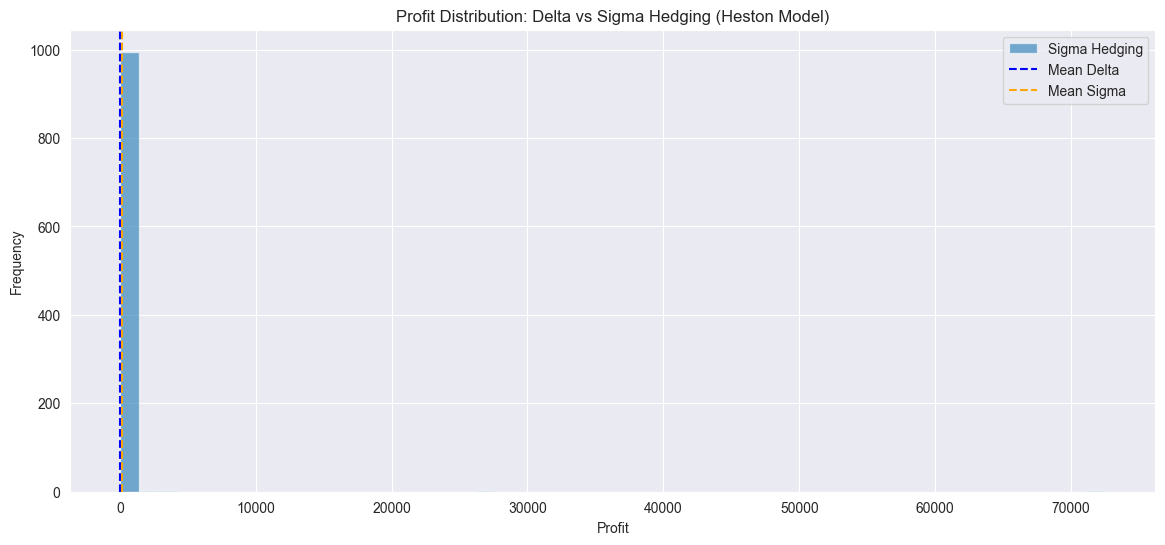

In [43]:
S0 = 100
K = 100
r = 0.039
T = 1
n_paths = 1000
n_steps = 252

profits_delta = hedge_strategy_heston(S0, K, r, T, n_paths, n_steps, strategy='delta')
profits_sigma = hedge_strategy_heston(S0, K, r, T, n_paths, n_steps, strategy='sigma')

# Plotting
plt.figure(figsize=(14,6))
#plt.hist(profits_delta, bins=50, alpha=0.6, label='Delta Hedging')
plt.hist(profits_sigma, bins=50, alpha=0.6, label='Sigma Hedging')
plt.axvline(np.mean(profits_delta), color='blue', linestyle='--', label='Mean Delta')
plt.axvline(np.mean(profits_sigma), color='orange', linestyle='--', label='Mean Sigma')
plt.title("Profit Distribution: Delta vs Sigma Hedging (Heston Model)")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()
